In [ ]:
#!pip install tensorboard

Epoch 1/1, Step 100/938, Loss 0.5984
Epoch 1/1, Step 200/938, Loss 0.3532
Epoch 1/1, Step 300/938, Loss 0.1747
Epoch 1/1, Step 400/938, Loss 0.1709
Epoch 1/1, Step 500/938, Loss 0.1454
Epoch 1/1, Step 600/938, Loss 0.1726
Epoch 1/1, Step 700/938, Loss 0.2763
Epoch 1/1, Step 800/938, Loss 0.1220
Epoch 1/1, Step 900/938, Loss 0.1584


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 64 but got size 16 for tensor number 156 in the list.

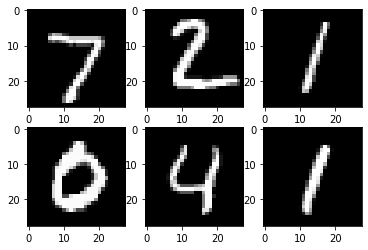

In [2]:
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist')

#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyprparameters
input_size = 784   #28*28
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001

#MNIST datasets
train_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=True,
                                          transform=transforms.ToTensor(),
                                          download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=False,
                                         transform=transforms.ToTensor())

#data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

example = iter(test_loader)
example_data, example_targets = example.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('minist_images', img_grid)
writer.close()
#sys.exit()

#fully connected nn with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
            #no activation and softmax function at the end
        return out
        
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer.add_graph(model, example_data.reshape(-1, 28*28))

#train the model
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #orign shape [100, 1, 28, 28]
        #resized [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{n_total_steps}, Loss {loss.item():.4f}')
            writer.add_scalar('traning loss ',running_loss / 100, epoch * n_total_steps * i)
            writer.add_scalar('Accuracy ',running_correct / 100, epoch * n_total_steps * i)
            running_loss = 0.0
            running_correct = 0
            
#test the model
#In test phase we dont need to compute gradients
labels = []
preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels1 in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels1 = labels1.to(device)
        outputs = model(images)
        
        # value , index
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels1.size(0)
        n_correct += (predicted == labels1).sum().item()
        
        class_predictions = [F.softmax(outputs, dim=0) for output in outputs]
        
        preds.append(class_predictions)
        labels.append(predicted)
    
    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels = torch.cat(labels)    
        
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the test images: {acc}%')

classes = range(10)
for i in classes:
    label_i = labels == i
    preds_i = pred[:, i]
    writer.add_pr_curve(str(i), label_i, preds_i, global_step=0)
    writer.close()

        

In [3]:
!tensorboard --logdir runs/mnist

2022-07-02 12:41:35.290051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-02 12:41:35.290078: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-02 12:41:36.915495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-02 12:41:36.915527: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-02 12:41:36.915545: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nikserver): /proc/driver/nvidia/version does not exist

NOTE: Using experimental fast data loading logic. To disable, pass